This notebook demonstrates the functionality of our 3D generator class onto two examples of data: 
- Grayscale CT scans
- RGB cat and dog GIfs

**Note:** 

* The application and main purpose of our generator is to be used during training a 3D Convolutional Neural Network as for data augmentation purposes.  
* In this notebook the before and after of a 3D volume is compared solely to demonstrate the functionality of our generator. The content of this notebook is not recommended as an appropriate usecase of the generator.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd   

#libraries for 2D and 3D visualisation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from plotly.tools import FigureFactory as FF
from skimage import measure
import scipy
import time

# Example 1:  Grayscale CT Chest Scans

**CT dimensions (length, height, width)**

## Load Data Info

In [2]:
info = pd.read_csv('ct_info.csv')
info.head()

,patient_id,scan_id,label
0,0,3131,1
1,1,3143,1
2,10,3152,1
3,1065,3104,1
4,1066,3105,1


In [3]:
info.label.value_counts()

3    19
2    19
1    19
Name: label, dtype: int64

 **Labels should start by 0** instead of 1 so we need to make the appropriate changes.

In [4]:
info['label'].replace({1:0, 2:1, 3:2},inplace=True)
info.label.value_counts()

2    19
1    19
0    19
Name: label, dtype: int64

## Split IDs to train and test test 80/20

In [5]:
train = info['patient_id'].sample(frac = 0.8).to_list()
validation = list(set(train)^set(info['patient_id']))

#make the train/test IDs a list
train = [str(i) for i in train]
validation = [str(i) for i in validation]

#create dictionary containing the train/test ID list
dictionary = {
    'train': train,
    'validation': validation}

In [6]:
#create a dictionary of the labels where key and values are charcters.
labels = pd.Series(info.label.values, index = info.patient_id.astype(str)).to_dict()

## Import our Generator

In [7]:
from Image3DGenerator import DataGenerator

## Transformations applied: Rotation, Gaussian Noise, Normalisation

In [17]:
# Parameters
params = { #ct dimensions
          'dim': (100,100,100),
           #desired batch size 
          'batch_size': 10,
          'n_classes': 3,
           #number of channels, since grayscale n_channels =1
          'n_channels': 1,
          'rotation': True,
          'normalisation': True,
           #minimum voxel value of ct scans
          'min_bound': 0,
           #maximum voxel value of ct scans
          'max_bound': 1,
          'gaussian_noise': True,
          'noise_mean': 0,
          'noise_std': 0.01,
          'shuffle': True,
          'rotate_std':45,
           #path of the folder containing the data
          'path':'./new_data',
          'display_ID':True}

In [18]:
# Generators
training_generator = DataGenerator(dictionary['train'], labels, **params)
validation_generator = DataGenerator(dictionary['validation'], labels, **params)

**Note:** At this point you are all set. The next step is to add your generators to model.fit() to start training with data augmentation.

## Visual example of a random transformation using our generator

In [19]:
X, y = training_generator.__getitem__(1)

IDs used:  ['1674', '10', '0', '1675', '1065', '107', '1075', '1069', '117', '108']


In [20]:
X.shape, y.shape

((10, 100, 100, 100, 1), (10, 3))

**Comment:** 
- The generator randomly choose a batch of 10 IDs from the train list and applied random transformations.

- We can see from the shapes that X is a matrix containing a batch of 10 grayscale (n_channels = 1) volumes while y is one hot encoded.

Let's take the first ID to compare the original volume with the one produced by the generator

In [21]:
ct_original = np.load('./new_data/1674.npy')
ct_transformed = X[0]

In [22]:
ct_original.shape, ct_transformed.shape

((100, 100, 100), (100, 100, 100, 1))

**Comment:** From the shape of ct_transformed we can see that the volume in the right format required from tensorflow.

In [23]:
#remove the colour channel
ct_transformed = ct_transformed.reshape(ct_transformed.shape[:3])
ct_transformed.shape

(100, 100, 100)

## 2D Visualisation of original vs transformed

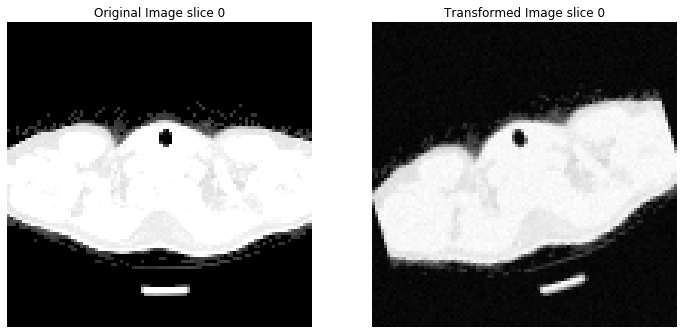

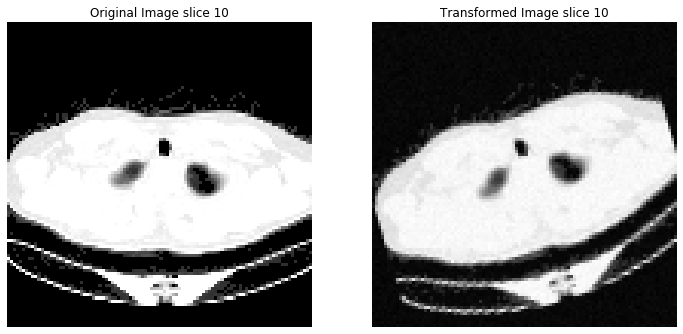

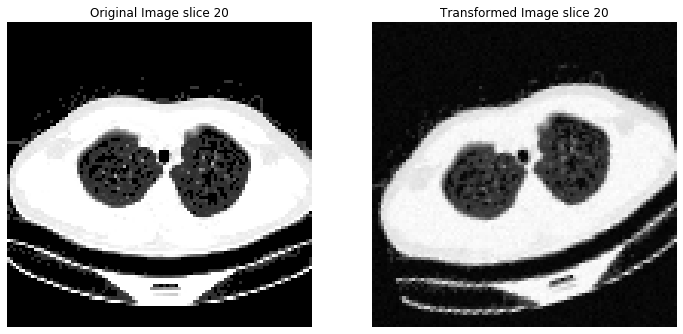

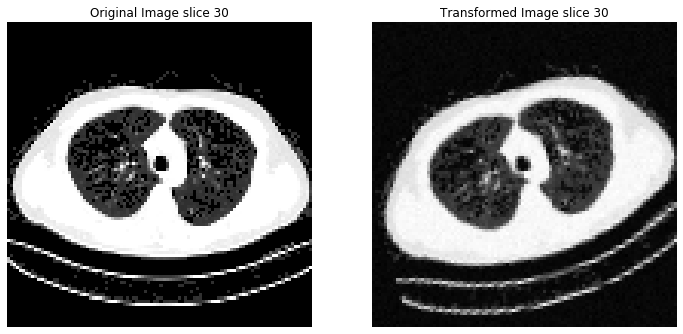

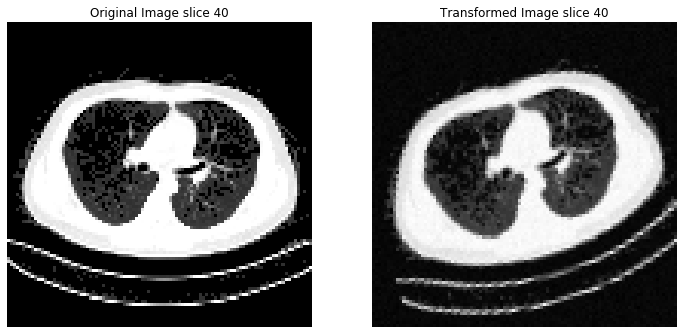

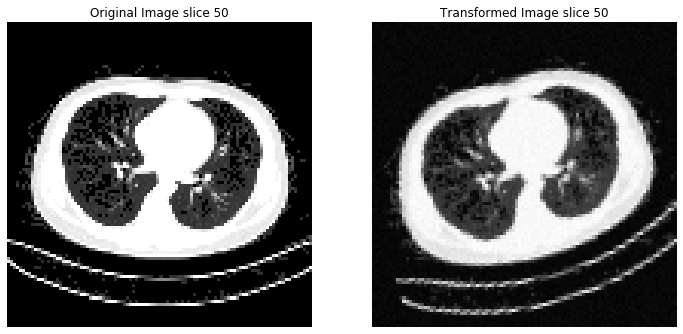

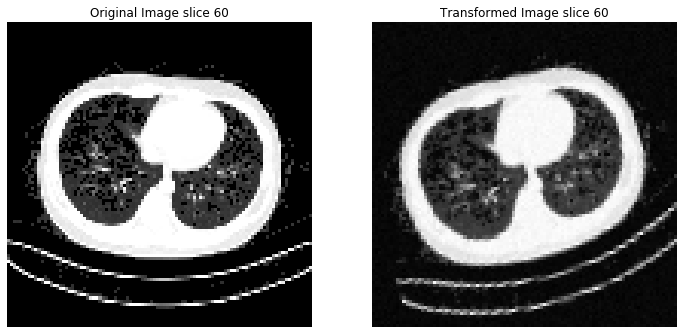

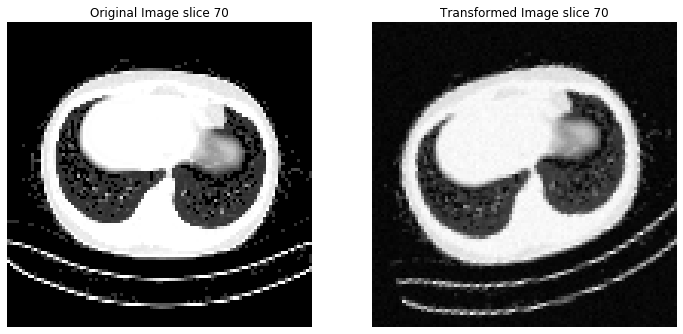

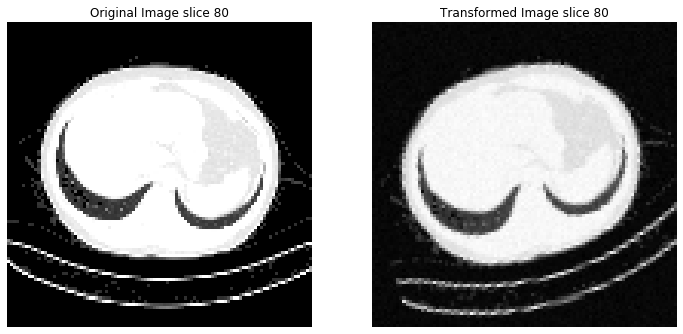

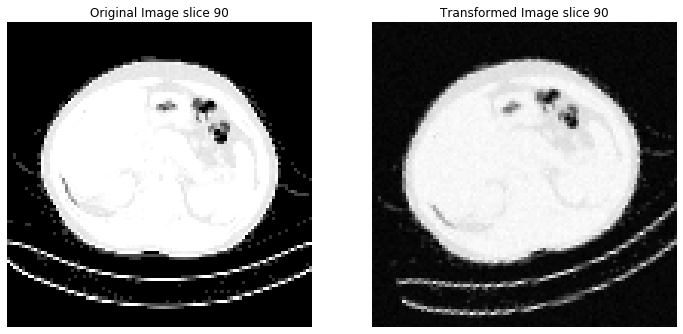

In [24]:
for i in range(0, ct_original.shape[0], 10):

            fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,12) )

            ax1.imshow(ct_original[i], cmap ='gray')
            ax1.axis('off')
            ax1.set_title('Original Image slice %d' % (i))
            ax2.imshow(ct_transformed[i], cmap ='gray')
            ax2.axis('off')
            ax2.set_title('Transformed Image slice %d' % (i))
            
            plt.show()

## Reduce the size of 3D volumes to speed of the 3D rendering

In [25]:
new_dim = 30
current_dim = ct_original.shape[0]

# Original
ct_original_resized = scipy.ndimage.zoom(ct_original, (new_dim/current_dim, new_dim/current_dim, new_dim/current_dim), mode='nearest')

#normalize voxels to be between 0 and 1.
ct_original_resized = (ct_original_resized - ct_original_resized.min())/(ct_original_resized.max() - ct_original_resized.min())


# Transformed
ct_transformed_resized = scipy.ndimage.zoom(ct_transformed, (new_dim/current_dim, new_dim/current_dim, new_dim/current_dim), mode='nearest')

#normalize voxels to be between 0 and 1.
ct_transformed_resized = (ct_transformed_resized - ct_transformed_resized.min())/(ct_transformed_resized.max() - ct_transformed_resized.min())

Reference for the following functions: https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

In [26]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold) 
    return (verts, faces)

        
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=0.7)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()

In [27]:
v_original, f_original = make_mesh(ct_original_resized, ct_original_resized.mean())
v_transformed, f_transformed = make_mesh(ct_transformed_resized, ct_transformed_resized.mean())

Transposing surface
Calculating surface
Transposing surface
Calculating surface


## CT original

Drawing


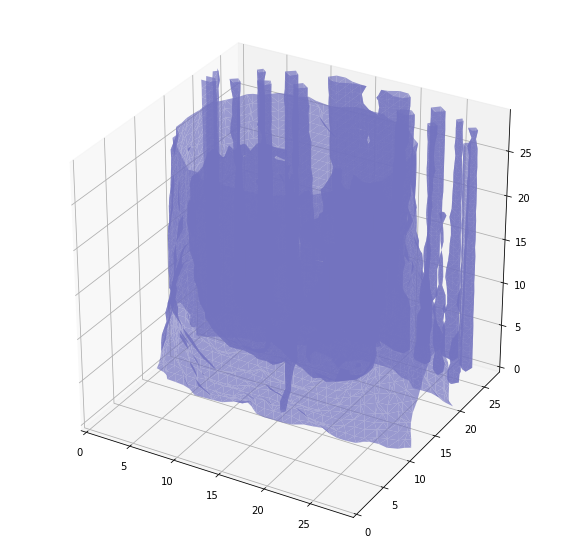

In [28]:
plt_3d(v_original, f_original)

## CT after transformations from generator

Drawing


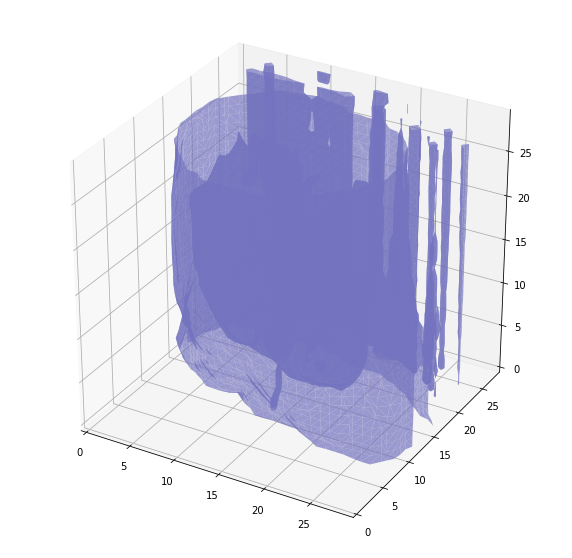

In [29]:
plt_3d(v_transformed, f_transformed)

# Example 2: 

**RGB gifs of cats and dogs, each with dimensions (total frames, image_height, image_width)**

## Create a train and validation list containing the data IDs and a dictionary with their labels

In [35]:
train_list = ['cat_1', 'dog_1', 'dog_2']
validation_list = ['cat_2', 'dog_3']
pet_dictionary = {'cat_1':0, 'cat_2':0, 'dog_1':1, 'dog_2':1, 'dog_3':1,
}

In [36]:
# Parameters
new_params = {'dim': (4,100,100),
          'batch_size': 1,
          'n_classes': 2,
          'n_channels': 3,
          'rotation': True,
          'normalisation': True,
          'min_bound': 0,
          'max_bound': 1,
          'gaussian_noise': True,
          'noise_mean': 0,
          'noise_std': 0.1,
          'shuffle': True,
          'rotate_std':30,
          'path':'./new_cat_dogs',
          'display_ID':True}

## Generator

In [37]:
pet_train_generator = DataGenerator(train_list, pet_dictionary, **new_params)

In [38]:
X_new, Y_new = pet_train_generator.__getitem__(1)

IDs used:  ['dog_2']


In [39]:
original_dog = np.load('./new_cat_dogs/dog_2.npy')

In [40]:
original_dog.shape

(4, 100, 100, 3)

In [41]:
transformed_dog = X_new[0]

In [42]:
transformed_dog.shape

(4, 100, 100, 3)

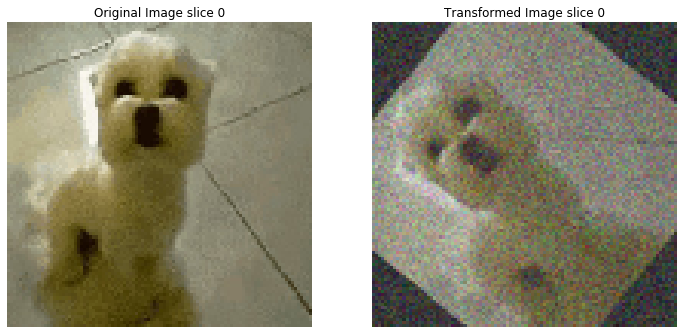

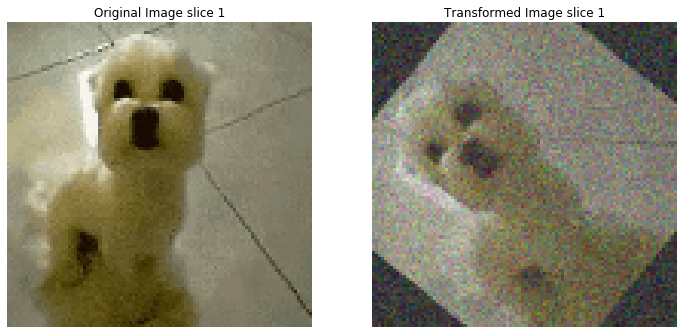

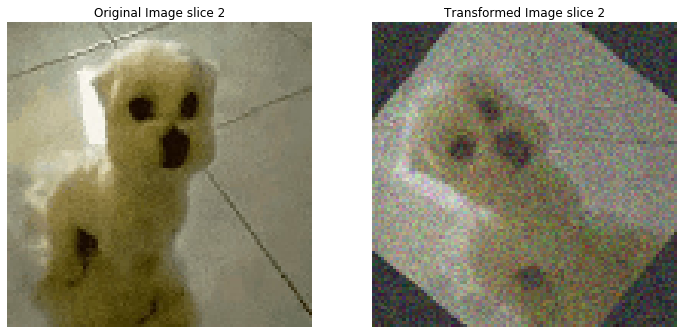

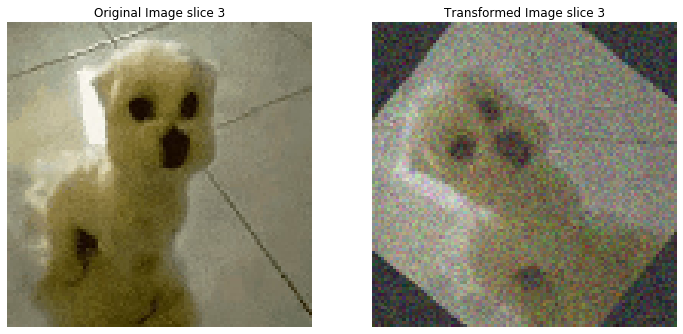

In [43]:
for i in range(original_dog.shape[0]):

            fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,12) )

            ax1.imshow(original_dog[i])
            ax1.axis('off')
            ax1.set_title('Original Image slice %d' % (i))
            ax2.imshow(transformed_dog[i])
            ax2.axis('off')
            ax2.set_title('Transformed Image slice %d' % (i))
            
            plt.show()